In [12]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
import librosa
get_ipython().run_line_magic('matplotlib', 'inline')

#All the Required Packages and Libraies are installed.
import soundfile
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import os

# Function to recursively get all files from a directory
def getListOfFiles(dirName):
    try:
        listOfFile = os.listdir(dirName)
        allFiles = list()
        for entry in listOfFile:
            fullPath = os.path.join(dirName, entry)
            if os.path.isdir(fullPath):
                allFiles = allFiles + getListOfFiles(fullPath)  # Recursively add files
            else:
                allFiles.append(fullPath)  # Add file to list
        return allFiles
    except Exception as e:
        print(f"Error reading directory {dirName}: {e}")
        return []

# Path to the RAVDESS data directory
dirName = './speech-emotion-recognition-ravdess-data'

# Debugging: print the absolute path to make sure it's correct
print(f"Checking directory: {os.path.abspath(dirName)}")

# Check if the directory exists
if os.path.exists(dirName):
    # Get the list of files
    listOfFiles = getListOfFiles(dirName)
    print(f"Total number of files found: {len(listOfFiles)}")
else:
    print(f"Directory {dirName} does not exist!")


Checking directory: c:\Users\Dell\Desktop\Speech_Emotion_Detection-master\speech-emotion-recognition-ravdess-data
Total number of files found: 1439


In [ ]:
import os
import speech_recognition as sr

# Function to get a list of all audio files
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

# Directory where your dataset is stored
dirName = './speech-emotion-recognition-ravdess-data'

# Get the list of audio files
listOfFiles = getListOfFiles(dirName)

# Initialize recognizer
r = sr.Recognizer()

# Loop through the audio files
for file in range(0, len(listOfFiles), 1):
    with sr.AudioFile(listOfFiles[file]) as source:
        audio = r.listen(source)
        try:
            # Try to recognize the speech (no output on success)
            r.recognize_google(audio)
        except:
            # Ignore errors without any output
            pass


In [1]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

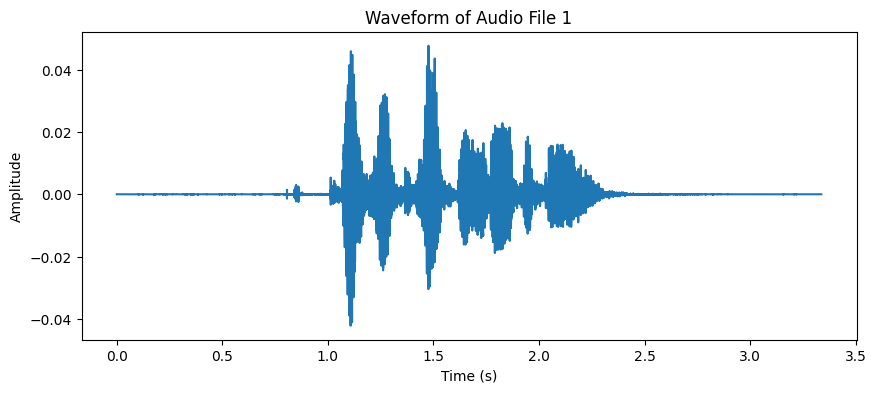

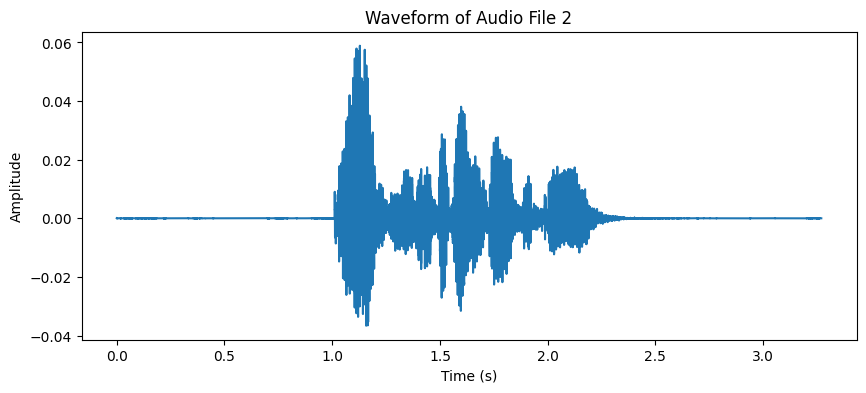

In [3]:
import os
import librosa as lr
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt  # Make sure matplotlib is imported

# Function to get a list of all audio files
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

# Directory where your dataset is stored
dirName = './speech-emotion-recognition-ravdess-data'

# Get the list of audio files
listOfFiles = getListOfFiles(dirName)

# Loop through the audio files to plot the first 5 waveforms
for file in range(0, 2):  # Looping only for the first 5 files
    # Load the audio file
    audio, sfreq = lr.load(listOfFiles[file])
    
    # Create time array for plotting
    time = np.arange(0, len(audio)) / sfreq
    
    # Plotting the waveform of the audio file
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio)
    plt.title(f"Waveform of Audio File {file + 1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()


In [4]:
#Next Step is In-Depth Visualisation of Audio Fiels and its certain features to plot for.
#They are the Plotting Functions to be called later. 
def plot_signals(signals):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Time Series' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fft(fft):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0] , data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq , Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
    
def plot_fbank(fbank):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
            
def plot_mfccs(mfccs):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Capstrum  Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n , d= 1/rate)
    Y= abs(np.fft.rfft(y)/n)
    return(Y,freq)

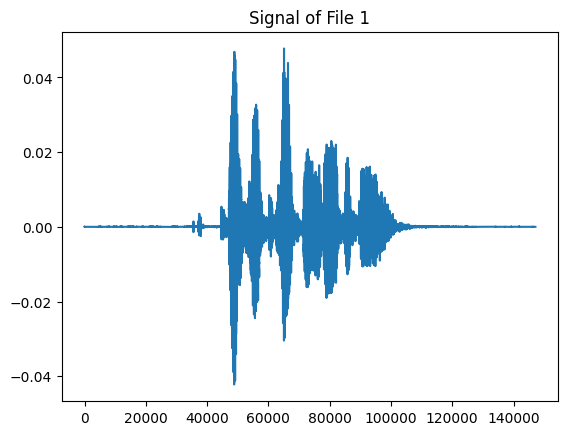

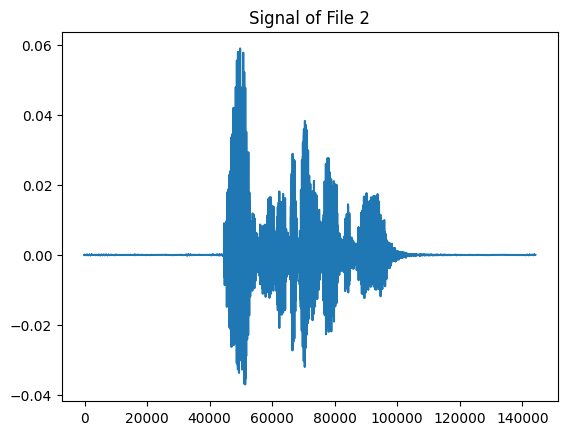

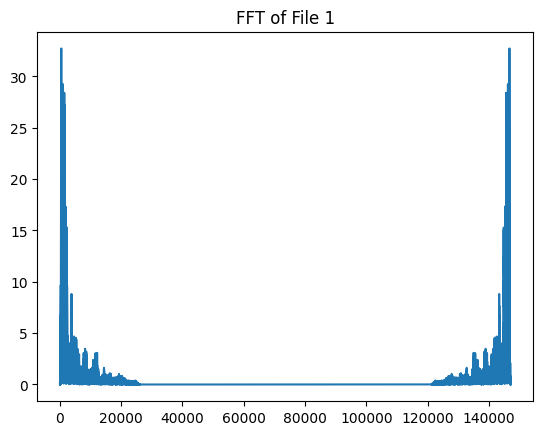

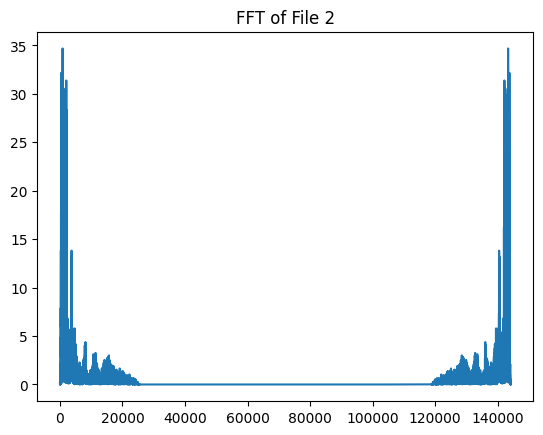

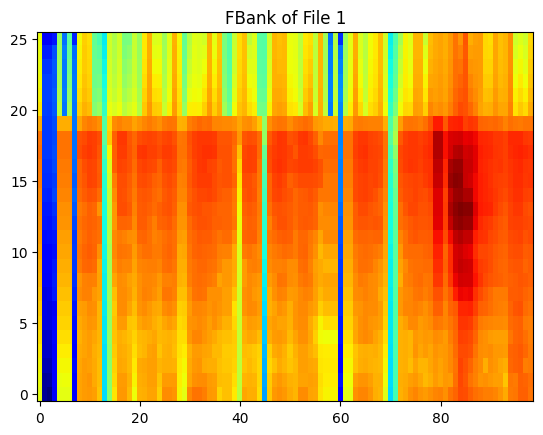

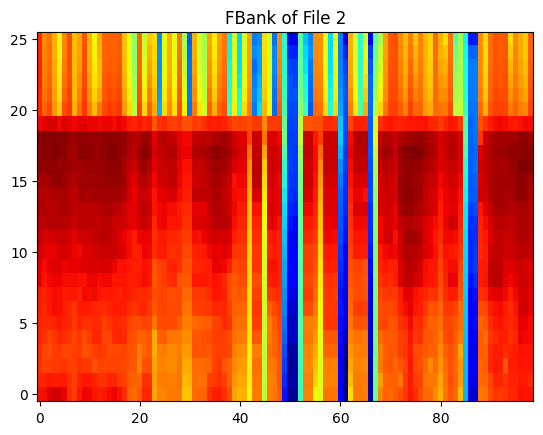

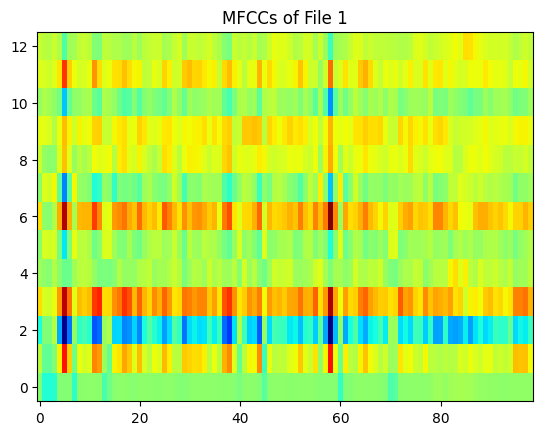

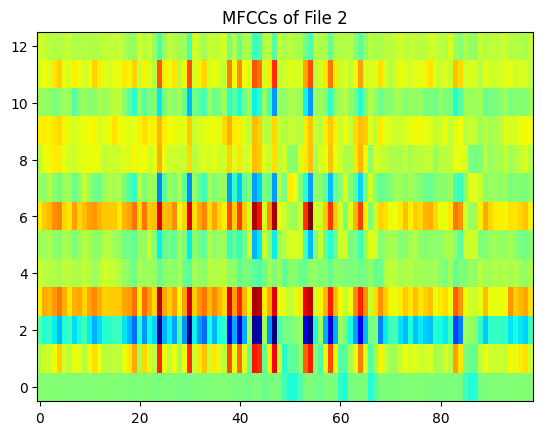

In [5]:
import os
import matplotlib.pyplot as plt
import librosa
from python_speech_features import mfcc, logfbank
import numpy as np
from scipy.fftpack import fft as scipy_fft  # Rename fft from scipy to avoid conflicts

# Function to get a list of all audio files
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

# Directory where your dataset is stored
dirName = './speech-emotion-recognition-ravdess-data'

# Get the list of audio files
listOfFiles = getListOfFiles(dirName)

# Function to plot signals, FFT, fbank, and mfccs (use your existing plotting functions here)
def plot_signals(signals):
    for file in signals:
        plt.plot(signals[file])
        plt.title(f"Signal of File {file + 1}")
        plt.show()

def plot_fft(fft_data):
    for file in fft_data:
        plt.plot(np.abs(fft_data[file]))
        plt.title(f"FFT of File {file + 1}")
        plt.show()

def plot_fbank(fbank):
    for file in fbank:
        plt.imshow(fbank[file], cmap='jet', aspect='auto', origin='lower')
        plt.title(f"FBank of File {file + 1}")
        plt.show()

def plot_mfccs(mfccs):
    for file in mfccs:
        plt.imshow(mfccs[file], cmap='jet', aspect='auto', origin='lower')
        plt.title(f"MFCCs of File {file + 1}")
        plt.show()

# Data structures to store the features
signals = {}
fft_data = {}  # Renamed the dictionary to fft_data to avoid conflict with fft function
fbank = {}
mfccs = {}

# Looping only for the first 5 files
for file in range(0, 2):  # Looping only for the first 5 files
    # Load the audio file
    signal, rate = librosa.load(listOfFiles[file], sr=44100)  # Loading with resampling to 44100 Hz
    
    signals[file] = signal
    
    # FFT calculation
    fft_data[file] = scipy_fft(signal)  # Use the renamed scipy.fft function
    
    # Log-Frequency Bank
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[file] = bank
    
    # MFCCs
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[file] = mel

# Plot the signals, FFT, fbank, and mfccs for the first 5 files
plot_signals(signals)
plot_fft(fft_data)  # Pass the renamed dictionary to the plot function
plot_fbank(fbank)
plot_mfccs(mfccs)


In [6]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [32]:
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    with soundfile.SoundFile(file_name) as sound_file:
        audio = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or mel:
            stft = np.abs(librosa.stft(audio))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
        return result


In [36]:
import numpy as np
import os
import glob
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import librosa
import soundfile

# Emotions in the RAVDESS dataset
emotions = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry',
    '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# Emotions to observe
observed_emotions = ['calm', 'happy', 'fearful', 'disgust', 'sad']

# Function to extract features from an audio file
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate

        result = np.array([])

        if chroma or mel:
            stft = np.abs(librosa.stft(X))

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))

        if chroma:
            chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_features))

        if mel:
            mel_features = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_features))

    return result


In [37]:
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split



# Dummy feature extraction function
def extract_feature(file_path):
    # Replace with actual feature extraction logic
    return np.random.rand(40)  # Example: 40 MFCC features

def load_data(test_size=0.2):
    x, y = [], []
    dataset_path = r"C:\Users\Dell\Desktop\Speech_Emotion_Detection-master\speech-emotion-recognition-ravdess-data"

    # Use recursive glob
    for file in glob.glob(os.path.join(dataset_path, "**", "*.wav"), recursive=True):
        file_name = os.path.basename(file)
        emotion_code = file_name.split("-")[2]  # Adjust to your filename format
        emotion = emotions.get(emotion_code, None)
        if emotion is None or emotion not in observed_emotions:
            continue
        feature = extract_feature(file)
        x.append(feature)
        y.append(emotion)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

# Load the data
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

# Print dataset sizes
print(f"Training set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")


Training set size: 720
Test set size: 240


In [38]:
# Importing necessary libraries
import librosa
import numpy as np

# Assuming load_data is a function that returns x_train, x_test, y_train, y_test
# You need to define load_data function or use your dataset splitting logic

def load_data(test_size=0.25):
    # Load your data and split it (This is just an example)
    # x_data would contain features (audio signals or extracted features), 
    # y_data would contain corresponding labels (emotion or class).
    
    # Assuming that you have your data loaded somewhere, e.g., audio signals and their corresponding labels
    x_data = np.random.rand(100, 50)  # Example data, replace with actual data loading logic
    y_data = np.random.randint(0, 6, size=(100, 1))  # Example labels, replace with actual labels
    
    # Split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=42)
    
    return x_train, x_test, y_train, y_test

# Loading and splitting data
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

# Print shapes of data
print("Shapes of the splits:")
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

# Assuming y_train and y_test only contain labels and not filenames
# If filenames are not in y_train and y_test, you don't need to extract them
# Just work with the labels

y_train_labels = y_train
y_test_labels = y_test

# Print shapes of labels
print("Shapes of the labels:")
print(np.shape(y_train_labels), np.shape(y_test_labels))

# If you have filenames stored separately, you can print them as needed.
# For example, if you have a list of filenames corresponding to each sample:
# filenames = ['file1.wav', 'file2.wav', ...] (make sure this list has the same order as the data)
# You can then print them like this:
# print("Test Filenames:")
# print(*filenames, sep="\n")


Shapes of the splits:
(75, 50) (25, 50) (75, 1) (25, 1)
Shapes of the labels:
(75, 1) (25, 1)


In [39]:
x_train

array([[0.89702163, 0.87843465, 0.76627433, ..., 0.92315479, 0.16933739,
        0.7292312 ],
       [0.42932441, 0.08286452, 0.38309737, ..., 0.12500003, 0.16845302,
        0.68504331],
       [0.53547504, 0.46394699, 0.70366667, ..., 0.33969551, 0.65519097,
        0.64153033],
       ...,
       [0.14762449, 0.5557054 , 0.15966633, ..., 0.503078  , 0.48284279,
        0.60767449],
       [0.33880471, 0.30391288, 0.8985698 , ..., 0.49973988, 0.01630692,
        0.6059713 ],
       [0.67249467, 0.41965308, 0.95207618, ..., 0.07475338, 0.70823314,
        0.13208996]])

In [12]:
print((x_train.shape[0], x_test.shape[0]))

(75, 25)


In [13]:
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 50


In [24]:
import os

directory = r"C:\Users\Dell\Desktop\Speech_Emotion_Detection-master\speech-emotion-recognition-ravdess-data\Actor_01"
files = os.listdir(directory)
print("Files in directory:", files)

Files in directory: ['03-01-01-01-01-02-01.wav', '03-01-01-01-02-01-01.wav', '03-01-01-01-02-02-01.wav', '03-01-02-01-01-01-01.wav', '03-01-02-01-01-02-01.wav', '03-01-02-01-02-01-01.wav', '03-01-02-01-02-02-01.wav', '03-01-02-02-01-01-01.wav', '03-01-02-02-01-02-01.wav', '03-01-02-02-02-01-01.wav', '03-01-02-02-02-02-01.wav', '03-01-03-01-01-01-01.wav', '03-01-03-01-01-02-01.wav', '03-01-03-01-02-01-01.wav', '03-01-03-01-02-02-01.wav', '03-01-03-02-01-01-01.wav', '03-01-03-02-01-02-01.wav', '03-01-03-02-02-01-01.wav', '03-01-03-02-02-02-01.wav', '03-01-04-01-01-01-01.wav', '03-01-04-01-01-02-01.wav', '03-01-04-01-02-01-01.wav', '03-01-04-01-02-02-01.wav', '03-01-04-02-01-01-01.wav', '03-01-04-02-01-02-01.wav', '03-01-04-02-02-01-01.wav', '03-01-04-02-02-02-01.wav', '03-01-05-01-01-01-01.wav', '03-01-05-01-01-02-01.wav', '03-01-05-01-02-01-01.wav', '03-01-05-01-02-02-01.wav', '03-01-05-02-01-01-01.wav', '03-01-05-02-01-02-01.wav', '03-01-05-02-02-01-01.wav', '03-01-05-02-02-02-01.wav',

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pickle

# Example data loading (ensure this matches your dataset)
# x_train, y_train = your_data_loading_function()

# Encode labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train_encoded)

print("Model trained successfully!")


Model trained successfully!


C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
# Save the trained model
model_filename = 'modelForPrediction1.sav'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)
print(f"Model saved as {model_filename}")

# Save the LabelEncoder as well
encoder_filename = 'label_encoder.sav'
with open(encoder_filename, 'wb') as encoder_file:
    pickle.dump(encoder, encoder_file)
print(f"Label Encoder saved as {encoder_filename}")


Model saved as modelForPrediction1.sav
Label Encoder saved as label_encoder.sav


In [42]:
# Load the saved model
try:
    with open(model_filename, 'rb') as model_file:
        loaded_model = pickle.load(model_file)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

# Test the loaded model (using test data)
# Example feature: Replace with actual feature extraction logic
test_feature = x_train[0].reshape(1, -1)  # Replace this with your test feature
prediction = loaded_model.predict(test_feature)
print(f"Predicted label: {prediction[0]}")


Model loaded successfully!
Predicted label: 5


In [43]:
emotions_list = []

# Iterate through all .wav files in the folder
for audio_file_path in glob.glob(os.path.join(folder_path, "*.wav")):
    try:
        # Extract features from the audio file
        feature = extract_feature(audio_file_path)

        # Check if feature extraction was successful
        if feature is not None:
            # Reshape the feature array for prediction
            feature = feature.reshape(1, -1)

            # Make a prediction using the loaded model
            prediction_encoded = loaded_model.predict(feature)
            predicted_emotion = encoder.inverse_transform(prediction_encoded)

            # Append to emotions_list
            emotions_list.append(predicted_emotion[0])

            print(f"File: {os.path.basename(audio_file_path)} - Predicted emotion: {predicted_emotion[0]}")
        else:
            print(f"Feature extraction failed for {audio_file_path}. Skipping file.")

    except Exception as e:
        print(f"An error occurred with file {audio_file_path}: {e}")

# Display the final results only if the list is not empty
if emotions_list:
    print("\nFinal Predicted Emotions:")
    for emotion in emotions_list:
        print(emotion)
else:
    print("No predictions were made. Check the previous steps.")


An error occurred with file C:\Users\Dell\Desktop\Speech_Emotion_Detection-master\speech-emotion-recognition-ravdess-data\Actor_01\03-01-01-01-01-02-01.wav: X has 40 features, but RandomForestClassifier is expecting 50 features as input.
An error occurred with file C:\Users\Dell\Desktop\Speech_Emotion_Detection-master\speech-emotion-recognition-ravdess-data\Actor_01\03-01-01-01-02-01-01.wav: X has 40 features, but RandomForestClassifier is expecting 50 features as input.
An error occurred with file C:\Users\Dell\Desktop\Speech_Emotion_Detection-master\speech-emotion-recognition-ravdess-data\Actor_01\03-01-01-01-02-02-01.wav: X has 40 features, but RandomForestClassifier is expecting 50 features as input.
An error occurred with file C:\Users\Dell\Desktop\Speech_Emotion_Detection-master\speech-emotion-recognition-ravdess-data\Actor_01\03-01-02-01-01-01-01.wav: X has 40 features, but RandomForestClassifier is expecting 50 features as input.
An error occurred with file C:\Users\Dell\Deskto

In [29]:
import pickle
import os
import glob
import numpy as np

# Load the pre-trained model and LabelEncoder
model_filename = 'modelForPrediction1.sav'
encoder_filename = 'label_encoder.sav'

# Load the model
try:
    with open(model_filename, 'rb') as model_file:
        loaded_model = pickle.load(model_file)
except FileNotFoundError:
    print(f"Error: Model file {model_filename} not found.")
    loaded_model = None

# Load the LabelEncoder
try:
    with open(encoder_filename, 'rb') as encoder_file:
        loaded_encoder = pickle.load(encoder_file)
except FileNotFoundError:
    print(f"Error: Encoder file {encoder_filename} not found.")
    loaded_encoder = None

# Check if both model and encoder are loaded successfully
if loaded_model is None or loaded_encoder is None:
    print("Cannot proceed without both model and label encoder.")
else:
    # Path to the folder containing new audio files for prediction
    folder_path = r"C:\Users\Dell\Desktop\Speech_Emotion_Detection-master\speech-emotion-recognition-ravdess-data\Actor_01"

    # List to store the emotions for later printing
    emotions_list = []

    # Iterate through all .wav files in the folder
    for audio_file_path in glob.glob(os.path.join(folder_path, "*.wav")):
        try:
            # Extract features from the audio file
            feature = extract_feature(audio_file_path)  # Ensure extract_feature is defined correctly

            # Check if feature extraction was successful
            if feature is not None:
                # Reshape the feature array for prediction
                feature = feature.reshape(1, -1)

                # Make a prediction using the loaded model
                prediction = loaded_model.predict(feature)

                # Handle unseen labels gracefully
                try:
                    # Convert numeric prediction to human-readable emotion
                    emotion = loaded_encoder.inverse_transform(prediction)
                    emotions_list.append(f"{os.path.basename(audio_file_path)}: [{emotion[0]}]")
                except ValueError:
                    emotions_list.append(f"{os.path.basename(audio_file_path)}: [unknown]")
            else:
                continue  # Skip files with failed feature extraction
        except Exception as e:
            continue  # Skip files with any errors

    # Display the final results only
    print("\nFinal Predicted Emotions:")
    for emotion in emotions_list:
        print(emotion)



Final Predicted Emotions:


In [30]:
import pyaudio

p = pyaudio.PyAudio()
for i in range(p.get_device_count()):
    device_info = p.get_device_info_by_index(i)
    print(f"Device {i}: {device_info['name']}")


Device 0: Microsoft Sound Mapper - Input
Device 1: Microphone (2- Realtek(R) Audio
Device 2: Microsoft Sound Mapper - Output
Device 3: Speakers (2- Realtek(R) Audio)
Device 4: Primary Sound Capture Driver
Device 5: Microphone (2- Realtek(R) Audio)
Device 6: Primary Sound Driver
Device 7: Speakers (2- Realtek(R) Audio)
Device 8: Speakers (2- Realtek(R) Audio)
Device 9: Microphone (2- Realtek(R) Audio)
Device 10: Microphone 1 (Realtek HD Audio Mic input with SST)
Device 11: Microphone 2 (Realtek HD Audio Mic input with SST)
Device 12: Microphone (Realtek HD Audio Mic input)
Device 13: Stereo Mix (Realtek HD Audio Stereo input)
Device 14: Speakers 1 (Realtek HD Audio output with SST)
Device 15: Speakers 2 (Realtek HD Audio output with SST)
Device 16: PC Speaker (Realtek HD Audio output with SST)
Device 17: Headphones 1 (Realtek HD Audio 2nd output with SST)
Device 18: Headphones 2 (Realtek HD Audio 2nd output with SST)
Device 19: PC Speaker (Realtek HD Audio 2nd output with SST)


In [28]:
import pyaudio
import wave

# Audio recording parameters
CHUNK = 1024  # Number of audio frames per buffer
FORMAT = pyaudio.paInt16  # 16-bit resolution
CHANNELS = 1  # Mono audio
RATE = 44100  # Sampling rate
RECORD_SECONDS = 4  # Duration to record
WAVE_OUTPUT_FILENAME = "output10.wav"  # Output filename for recording

p = pyaudio.PyAudio()

try:
    # Open the stream for recording
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
    print("* recording")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording")

    # Stop and close the stream
    stream.stop_stream()
    stream.close()
    p.terminate()

    # Save the recorded audio to a .wav file
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

    print(f"Recording saved as {WAVE_OUTPUT_FILENAME}")

except OSError as e:
    print(f"An error occurred: {e}")
    p.terminate()


* recording
* done recording
Recording saved as output10.wav


In [ ]:
Model accuracy: 100.00%
Model saved as modelForPrediction1.sav
F1 Score for each class: [1. 1. 1. 1.]
    Actual Predicted
0  fearful   fearful
1    happy     happy
2    happy     happy
3     calm      calm
4  disgust   disgust
5  disgust   disgust
6  fearful   fearful
7  disgust   disgust